<a href="https://colab.research.google.com/github/sevendaystoglory/ML-theory-to-practice/blob/main/RNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [553]:
import numpy as np

class SimpleRNN:
  def __init__(self, input_size, hidden_size, output_size):
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.W_xh = np.random.randn(hidden_size, input_size)*0.01
    self.W_hh = np.random.randn(hidden_size, hidden_size)*0.01
    self.W_hy = np.random.randn(output_size, hidden_size)*0.01
    self.b_h = np.zeros((hidden_size, 1))
    self.b_y = np.zeros((output_size, 1))

  def forward(self, x):
    self.h = np.zeros((len(x), self.hidden_size))
    y = []
    h_i = np.zeros((self.hidden_size, 1))
    for i, x_i in enumerate(x):
        x_i = np.array(x_i).reshape(-1,1)
        h_i = self.W_xh @ x_i + self.W_hh @ h_i + self.b_h
        y_i = self.W_hy @ h_i + self.b_y
        self.h[i] = h_i.flatten()
        y.append(y_i)
    # return self.W_hy
    self.o = np.array(y)
    return np.array(y)

  def backward(self, x, y, learning_rate):
    lr = learning_rate
    o = self.o
    T = o.shape[0]
    grad_h = np.zeros((self.hidden_size, 1))

    d_grad_w = np.zeros_like(self.W_hh)
    d_grad_u = np.zeros_like(self.W_xh)
    d_grad_v = np.zeros_like(self.W_hy)
    d_grad_o = np.zeros_like(self.b_y)
    d_grad_h = np.zeros_like(self.b_h)

    for i in range(T-1, -1, -1):
        x_i, o_i, y_i, h_i  =x[i], o[i], y[i], self.h[i]
        h_prev = self.h[i-1] if i > 0 else np.zeros_like(h_i)
        o_i = o_i.reshape(-1,1)
        x_i = x_i.reshape(-1,1)
        h_i = h_i.reshape(-1,1)
        y_i = y_i.reshape(-1,1)
        h_prev = h_prev.reshape(-1,1)
        grad_o = 2 * (o_i - y_i)
        d_grad_o += grad_o
        grad_h = self.W_hy.T @ grad_o + self.W_hh.T @ grad_h
        d_grad_w += grad_h @ h_prev.T
        d_grad_h += grad_h
        d_grad_v += grad_o @ h_i.T
        d_grad_u += grad_h @ x_i.T

        # update now
    self.W_hy -= lr * d_grad_v
    self.W_hh -= lr * d_grad_w
    self.W_xh -= lr * d_grad_u
    self.b_y -= lr * d_grad_o
    self.b_h -= lr * d_grad_h
    # print(self.W_hy)
    # print(self.W_hh)
    # print(self.W_xh)
    # print(self.b_y)
    # print(self.b_h)
    pass


In [554]:
import numpy as np
np.random.seed(42)
input_sequence = np.array([[1.0], [2.0], [3.0], [4.0]])
expected_output = np.array([[2.0], [3.0], [4.0], [5.0]])
rnn = SimpleRNN(input_size=1, hidden_size=5, output_size=1) # Train the RNN over multiple epochs

In [577]:
for epoch in range(10):
  output = rnn.forward(input_sequence)
  rnn.backward(input_sequence, expected_output, learning_rate=0.001)
print(output)

[[[2.18526922]]

 [[3.07913639]]

 [[3.99845648]]

 [[4.92548556]]]


In [212]:
class SimpleComp:
  def __init__(self, w, lr = 0.01):
    self.lr = lr
    self.w = w
  def forward(self, x):
    self.x = x
    return x*self.w
  def backward(self, y_pred, y):
    err = y_pred - y
    grad_y = 2 * err
    grad_w = self.x * grad_y
    grad_x = self.w * grad_y
    # step
    self.w -= self.lr * grad_w

In [240]:
f = SimpleComp(1, lr = 0.0009)
x=10
y = f.forward(x)
y

10

In [241]:
y = []
for steps in range(200):
  y_pred = f.forward(x)
  f.backward(y_pred, 2) #true label = 2
  y.append(f.w*x)

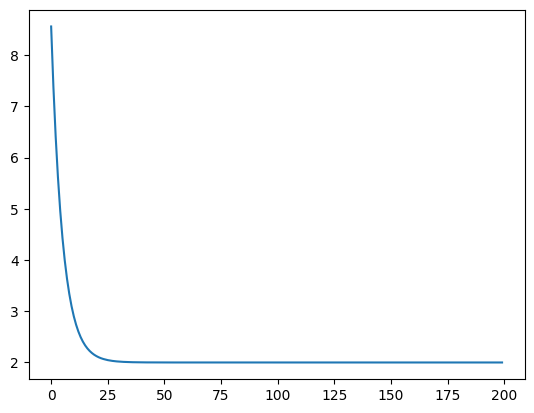

In [242]:
import matplotlib.pyplot as plt

plt.plot(np.arange(200), np.array(y))

In [472]:
import torch
import torch.nn as nn

class RNNtorch(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.W_xh = nn.Linear(input_size, hidden_size)
    self.W_hh = nn.Linear(hidden_size, hidden_size)
    self.W_hy = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    # x is a T, C tensor
    self.h = torch.zeros(self.hidden_size)
    pred = []
    for t in range(x.shape[0]):
      self.h = self.W_hh(self.h) + self.W_xh(x[t])
      y = self.W_hy(self.h)
      pred.append(y)
    return torch.stack(pred)


In [545]:
import numpy as np
np.random.seed(42)
x = torch.tensor([[1.0], [2.0], [3.0], [4.0]])
y = torch.tensor([[2.0], [3.0], [4.0], [5.0]])
rnn = RNNtorch(input_size=1, hidden_size=5, output_size=1) # Train the RNN over multiple epochs

In [546]:
pred = rnn(x)
pred

tensor([[-0.0119],
        [-0.3083],
        [-0.7851],
        [-1.2772]], grad_fn=<StackBackward0>)

In [552]:
import torch.optim as optim
optimizer = optim.Adam(params = rnn.parameters(), lr=0.0001)
for epoch in range(100):
  rnn.zero_grad
  pred = rnn(x)
  loss = torch.mean((pred - y)**2)
  loss.backward()
  optimizer.step()
print(pred)

tensor([[1.8126],
        [2.9238],
        [3.2975],
        [3.0961]], grad_fn=<StackBackward0>)
